### Step3B
### Identifying Authors by Organization / Entity

In [261]:
import os
import time
import subprocess

from pyspark.sql.functions import *

from pyspark.sql.types import *

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [262]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [263]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [264]:
df = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/safzal1/finalprojectdata_AfterStep2")

In [265]:
df.count()

1731801

### checking description of tweeterers

In [266]:
#df= df.dropDuplicates(["User_ID"])
#df= df.dropDuplicates(["RT_Status_Original_User_ID"])

In [267]:
df.count()

1731801

In [268]:
# for verified
df = df.filter(col('RT_Status_Original_User_Verified') == False)

In [269]:
df.count()

1031906

##### Definig keywords which will be used to match tweets with entities

In [270]:
Govt = ['government', 'govt', 'gov', 'federal', 'state', 'provincial', 'central', 'local', 'agency', 'official',
       'public office', 'embassy' , 'parliment', 'assembly', 'national', 'politics', 'minister']


School = ['school', 'student', 'teacher', 'class','award', 'high school', 'educate', 'educating', 'exams']

Uni = ['school','university','research','teaching','edu','college','master','medic','doctor',\
           'graduate','undergraduate','elementary','Learning', 'student', 'educate' ]
Nonprofit = ['ngo', 'socialist' 'non-profit', 'foundation', 'social', 'welfare', 'non profit', 'free', 'charity', 'donation', 'free of cost']

News = ['tv', 'channel', 'reporter', 'anchor', 'news', 'newsroom' 'newspaper', 'press', 'electronic media', 'media', 'anchor', 'program', 'headlines',
       'latest', 'updates', 'bulletin', 'journalist']

SM_Influencers = ['influencer', 'blogger','vlogger','star','celebrities','award', 'educator', 'content', 'brand', 'brand ambassador', 'sponsor', 'brandpartner', 'creative', 'actor','singer','writer','musician','actress','author','golfer']


In [271]:
Govt = '|'.join(Govt)
Uni = '|'.join(Uni)
School = '|'.join(School)
Nonprofit = '|'.join(Nonprofit)
News = '|'.join(News)
SM_Influencers = '|'.join(SM_Influencers)

In [272]:
Govt

'government|govt|gov|federal|state|provincial|central|local|agency|official|public office|embassy|parliment|assembly|national|politics|minister'

In [273]:
df = df.withColumn('Lower_User_Description', lower('User_Description'))
df = df.withColumn('Lower_User_Name', lower('User_Name'))
df = df.withColumn('Lower_RT_Status_Original_User_Screen_Name', lower('RT_Status_Original_User_Screen_Name'))
df = df.withColumn('Lower_RT_Status_Original_User_Description', lower('RT_Status_Original_User_Description'))

In [274]:
df = df.withColumn("Lower_User_Description", regexp_replace(df["Lower_User_Description"], "[^a-zA-Z0-9\\s]+", ""))
df = df.withColumn("Lower_RT_Status_Original_User_Description", regexp_replace(df["Lower_RT_Status_Original_User_Description"], "[^a-zA-Z0-9\\s]+", ""))



In [275]:
#df.select('Lower_User_Description', 'User_Description')

In [276]:
df = df.withColumn("Category", 
    when(col("If_Retweeted_Root") != "RT", 
        when(col("Lower_User_Description").rlike(Govt) | col("Lower_User_Name").rlike(Govt), "Government Entities").otherwise(
        when(col("Lower_User_Description").rlike(School) | col("Lower_User_Name").rlike(School), "School").
            when(col("Lower_User_Description").rlike(Uni) | col("Lower_User_Name").rlike(Uni), "University").
            when(col("Lower_User_Description").rlike(Nonprofit) | col("Lower_User_Name").rlike(Nonprofit), "Non Profit Org").
            when(col("Lower_User_Description").rlike(News) | col("Lower_User_Name").rlike(News), "News Outlets").
            when(col("Lower_User_Description").rlike(SM_Influencers) | col("Lower_User_Name").rlike(SM_Influencers), "Social Media Influencer").otherwise("others"))).otherwise(
        when(col("Lower_RT_Status_Original_User_Description").rlike(Govt) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(Govt), "Government Entities").otherwise(
        when(col("Lower_User_Description").rlike(School) | col("Lower_User_Name").rlike(School), "School").
            when(col("Lower_User_Description").rlike(Uni) | col("Lower_User_Name").rlike(Uni), "University").
            when(col("Lower_RT_Status_Original_User_Description").rlike(Nonprofit) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(Nonprofit), "Non Profit Org").
            when(col("Lower_RT_Status_Original_User_Description").rlike(News) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(News), "News Outlets").
            when(col("Lower_RT_Status_Original_User_Description").rlike(SM_Influencers) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(SM_Influencers), "Social Media Influencer").otherwise("others"))))

In [277]:
df_pd = df.groupBy('Category').agg(count('Tweet_ID').alias('Count')).toPandas()

In [278]:
df_pd.sort_values(by = 'Count', ascending = False, inplace = True)

In [279]:
df_all = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/safzal1/finalprojectdata_AfterStep2")
#df_all= df_all.dropDuplicates(["User_ID"])
#df_all= df_all.dropDuplicates(["RT_Status_Original_User_ID"])

In [280]:
df_all = df_all.withColumn('Lower_User_Description', lower('User_Description'))
df_all = df_all.withColumn('Lower_User_Name', lower('User_Name'))
df_all = df_all.withColumn('Lower_RT_Status_Original_User_Screen_Name', lower('RT_Status_Original_User_Screen_Name'))
df_all = df_all.withColumn('Lower_RT_Status_Original_User_Description', lower('RT_Status_Original_User_Description'))

In [281]:
df_all = df_all.withColumn("Lower_User_Description", regexp_replace(df_all["Lower_User_Description"], "[^a-zA-Z0-9\\s]+", ""))
df_all = df_all.withColumn("Lower_RT_Status_Original_User_Description", regexp_replace(df_all["Lower_RT_Status_Original_User_Description"], "[^a-zA-Z0-9\\s]+", ""))



In [282]:
df_all = df_all.withColumn("Category", 
    when(col("If_Retweeted_Root") != "RT", 
        when(col("Lower_User_Description").rlike(Govt) | col("Lower_User_Name").rlike(Govt), "Government Entities").otherwise(
        when(col("Lower_User_Description").rlike(Uni) | col("Lower_User_Name").rlike(Uni), "University").
            when(col("Lower_User_Description").rlike(School) | col("Lower_User_Name").rlike(School), "School").
            when(col("Lower_User_Description").rlike(Nonprofit) | col("Lower_User_Name").rlike(Nonprofit), "Non Profit Org").
            when(col("Lower_User_Description").rlike(News) | col("Lower_User_Name").rlike(News), "News Outlets").
            when(col("Lower_User_Description").rlike(SM_Influencers) | col("Lower_User_Name").rlike(SM_Influencers), "Social Media Influencer").otherwise("others"))).otherwise(
        when(col("Lower_RT_Status_Original_User_Description").rlike(Govt) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(Govt), "Government Entities").otherwise(
        when(col("Lower_RT_Status_Original_User_Description").rlike(Uni) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(Uni), "University").
            when(col("Lower_RT_Status_Original_User_Description").rlike(School) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(School), "School").
            when(col("Lower_RT_Status_Original_User_Description").rlike(Nonprofit) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(Nonprofit), "Non Profit Org").
            when(col("Lower_RT_Status_Original_User_Description").rlike(News) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(News), "News Outlets").
            when(col("Lower_RT_Status_Original_User_Description").rlike(SM_Influencers) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(SM_Influencers), "Social Media Influencer").otherwise("others"))))

In [283]:
df_all.count()

1731801

In [285]:
df_all.write.mode('overwrite').parquet('gs://msca-bdp-students-bucket/shared_data/safzal1/withCategories2')

In [286]:
df_verified = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/safzal1/finalprojectdata_AfterStep2")
#df_verified= df_verified.dropDuplicates(["User_ID"])
#df_verified= df_verified.dropDuplicates(["RT_Status_Original_User_ID"])

In [287]:
df_verified = df_verified.filter(col('RT_Status_Original_User_Verified') == True)

In [288]:
df_verified.count()

528905

In [289]:
df_verified = df_verified.withColumn('Lower_User_Description', lower('User_Description'))
df_verified = df_verified.withColumn('Lower_User_Name', lower('User_Name'))
df_verified = df_verified.withColumn('Lower_RT_Status_Original_User_Screen_Name', lower('RT_Status_Original_User_Screen_Name'))
df_verified = df_verified.withColumn('Lower_RT_Status_Original_User_Description', lower('RT_Status_Original_User_Description'))

In [290]:
df_verified = df_verified.withColumn("Lower_User_Description", regexp_replace(df_verified["Lower_User_Description"], "[^a-zA-Z0-9\\s]+", ""))
df_verified = df_verified.withColumn("Lower_RT_Status_Original_User_Description", regexp_replace(df_verified["Lower_RT_Status_Original_User_Description"], "[^a-zA-Z0-9\\s]+", ""))



In [291]:
df_verified = df_verified.withColumn("Category", 
    when(col("If_Retweeted_Root") != "RT", 
        when(col("Lower_User_Description").rlike(Govt) | col("Lower_User_Name").rlike(Govt), "Government Entities").otherwise(
        when(col("Lower_User_Description").rlike(Uni) | col("Lower_User_Name").rlike(Uni), "University").
            when(col("Lower_User_Description").rlike(School) | col("Lower_User_Name").rlike(School), "School").
            when(col("Lower_User_Description").rlike(Nonprofit) | col("Lower_User_Name").rlike(Nonprofit), "Non Profit Org").
            when(col("Lower_User_Description").rlike(News) | col("Lower_User_Name").rlike(News), "News Outlets").
            when(col("Lower_User_Description").rlike(SM_Influencers) | col("Lower_User_Name").rlike(SM_Influencers), "Social Media Influencer").otherwise("others"))).otherwise(
        when(col("Lower_RT_Status_Original_User_Description").rlike(Govt) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(Govt), "Government Entities").otherwise(
        when(col("Lower_RT_Status_Original_User_Description").rlike(Uni) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(Uni), "University").
            when(col("Lower_RT_Status_Original_User_Description").rlike(School) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(School), "School").
            when(col("Lower_RT_Status_Original_User_Description").rlike(Nonprofit) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(Nonprofit), "Non Profit Org").
            when(col("Lower_RT_Status_Original_User_Description").rlike(News) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(News), "News Outlets").
            when(col("Lower_RT_Status_Original_User_Description").rlike(SM_Influencers) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(SM_Influencers), "Social Media Influencer").otherwise("others"))))

In [292]:
df_pd_verified = df_verified.groupBy('Category').agg(count('Tweet_ID').alias('Count')).toPandas()

In [293]:
df_pd_verified.sort_values(by = 'Count', ascending = False, inplace = True)

In [294]:
sum_verified = df_pd_verified.Count.sum(axis = 0)

In [295]:
df_pd_verified.Count = (df_pd_verified.Count / sum_verified) * 100

In [296]:
sum_all = df_pd.Count.sum(axis = 0)
df_pd.Count = (df_pd.Count / sum_all) * 100

In [297]:
df_pd = pd.merge(df_pd, df_pd_verified, on ='Category')

In [298]:
df_pd_melted = pd.melt(df_pd, id_vars=['Category'], \
                                  value_vars=[
                                              'Count_x',\
                                                'Count_y'
                                             ],var_name='Y')

In [299]:
df_pd_melted

,Category,Y,value
0,others,Count_x,55.120912
1,Government Entities,Count_x,13.299370
2,News Outlets,Count_x,7.118575
3,School,Count_x,6.767380
4,Non Profit Org,Count_x,6.571335
5,University,Count_x,5.760505
6,Social Media Influencer,Count_x,5.361923
7,others,Count_y,22.264301
8,Government Entities,Count_y,36.577835
9,News Outlets,Count_y,19.874647


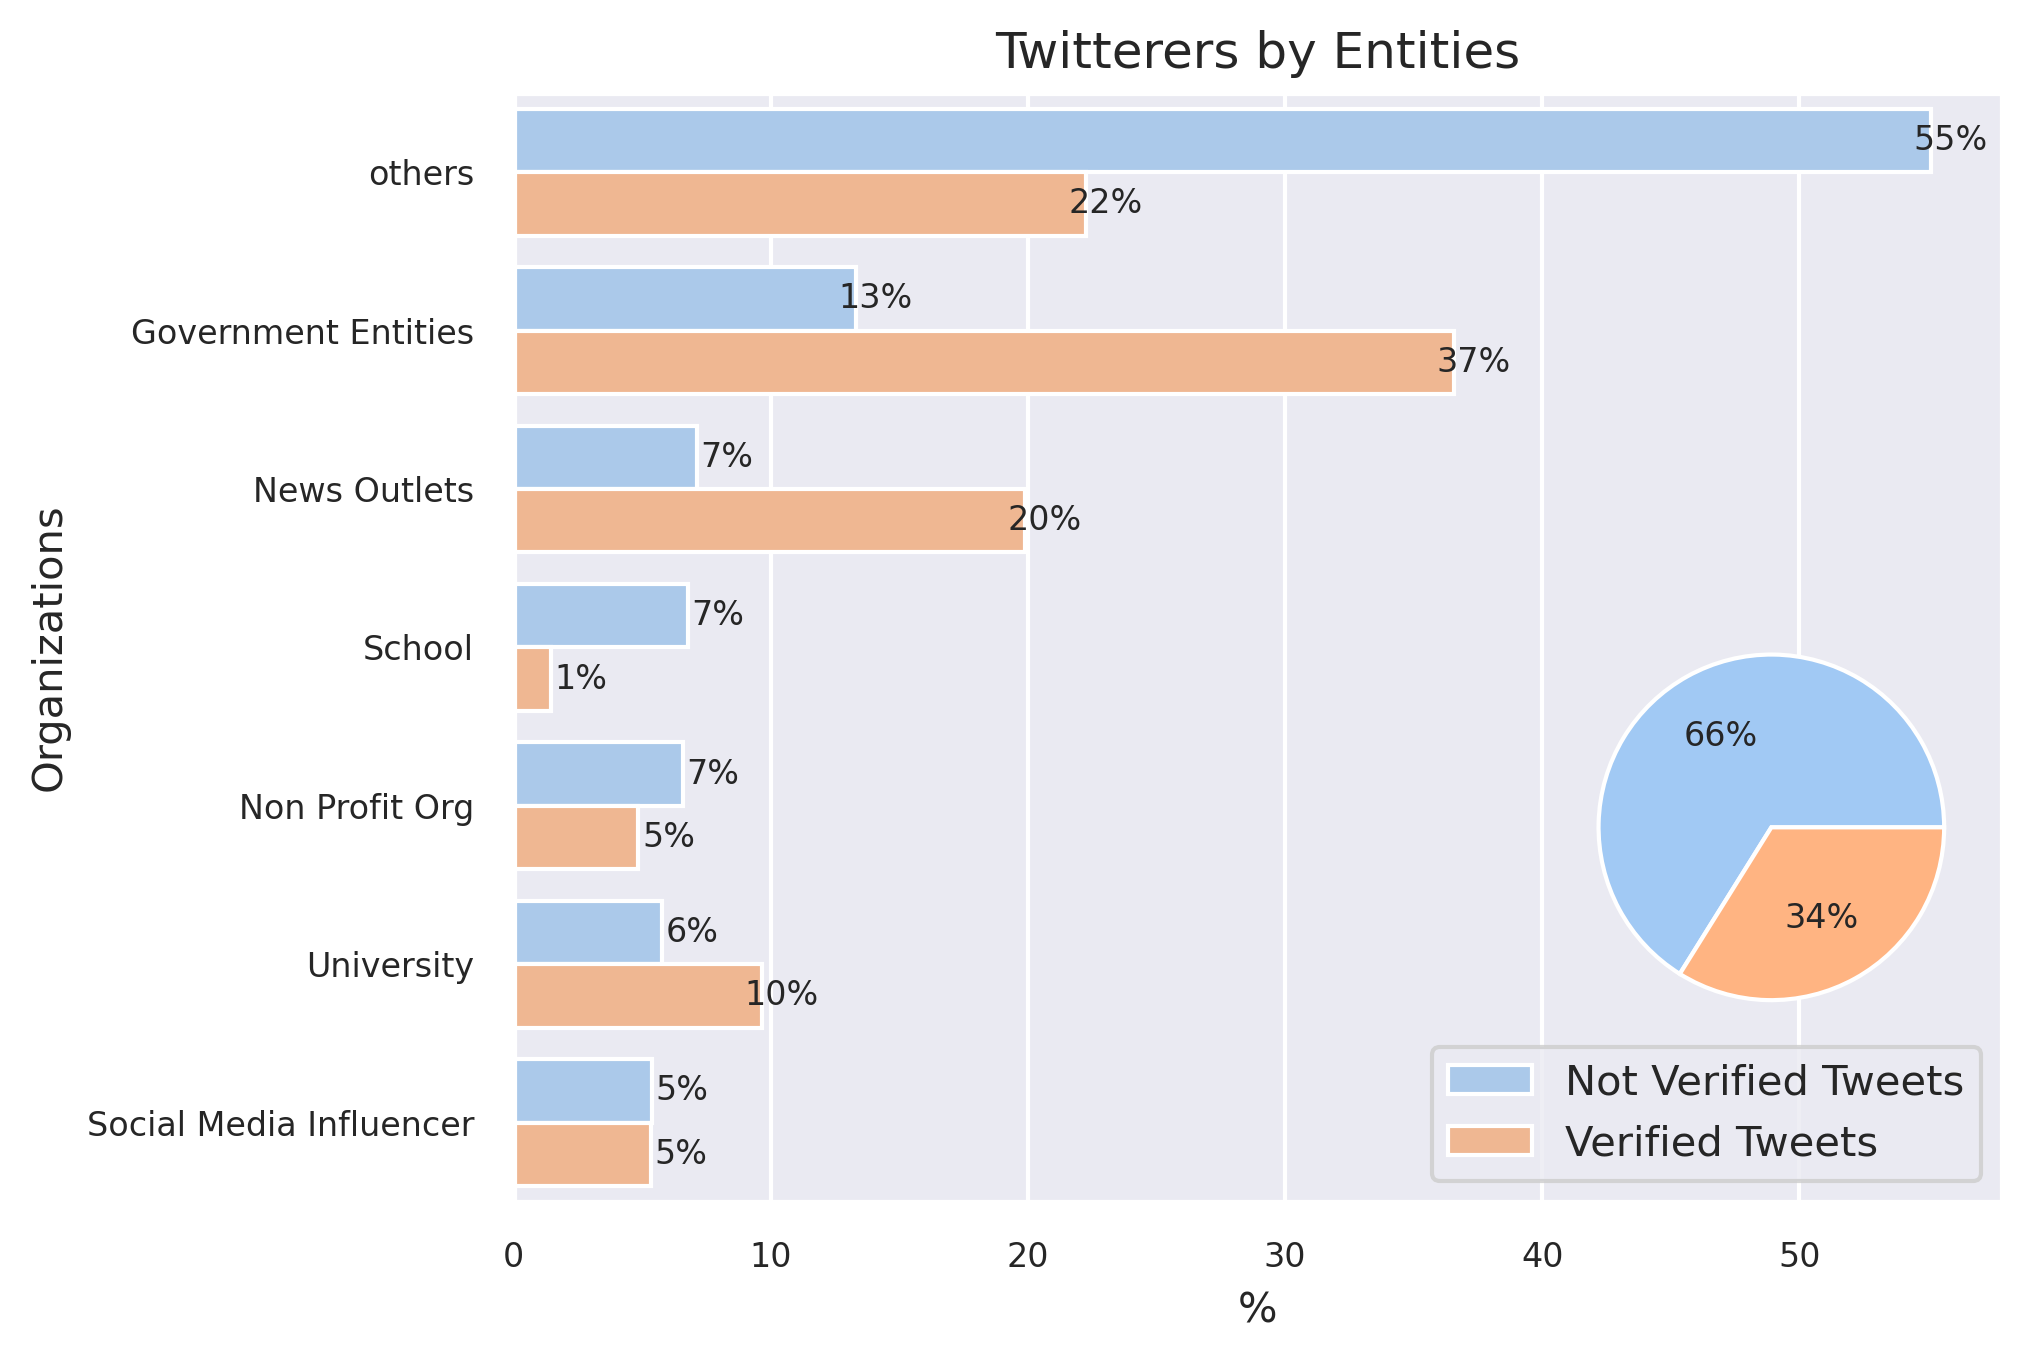

In [321]:
plt.figure(dpi = 300)
colors = sns.color_palette('pastel')[0:5]
ax = sns.barplot(y = 'Category', x = 'value', hue = 'Y', data = df_pd_melted, palette = colors)
plt.title('Twitterers by Entities')
plt.ylabel('Organizations', fontsize = 10)
plt.xlabel('%', fontsize = 10)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
legend_labels = ['Not Verified Tweets', 'Verified Tweets']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, legend_labels)

for p in ax.patches:
    value = '{:.0f}%'.format(p.get_width())
    x = p.get_x() + p.get_width() + 2.2
    y = p.get_y() + p.get_height() / 2
    ax.text(x, y, value, ha='right', va='center', fontsize=8)
plt.axes([0.53, 0.22, 0.5, 0.3])  # create a new axis in the bottom right corner
plt.pie([1031906,528905], autopct='%.0f%%', colors = colors, textprops={'fontsize': 8})
sns.set(rc={'legend.fontsize': 10})

plt.show()
    


### For all the tweets, finding average of retweets which they get by organizations

In [301]:
df.printSchema()

root
 |-- Tweet_ID: long (nullable = true)
 |-- RT_Status_RT_Count: long (nullable = true)
 |-- RT_Status_Like_Count: long (nullable = true)
 |-- RT_Status_Reply_Count: long (nullable = true)
 |-- RT_Stats_Quoted_Count: long (nullable = true)
 |-- RT_Status_Original_User_ID: long (nullable = true)
 |-- RT_Status_Original_User_Screen_Name: string (nullable = true)
 |-- RT_Status_Original_User_Location: string (nullable = true)
 |-- RT_Status_Original_User_Description: string (nullable = true)
 |-- RT_Status_Original_User_Verified: boolean (nullable = true)
 |-- RT_Status_Original_User_followers_count: long (nullable = true)
 |-- RT_Status_Original_User_statuses_count: long (nullable = true)
 |-- RT_Status_Original_User_listed_count: long (nullable = true)
 |-- RT_Status_Original_Tweet_Id: long (nullable = true)
 |-- RT_Status_Original_Tweet_Text: string (nullable = true)
 |-- RT_Status_Original_Tweet_Created_at: string (nullable = true)
 |-- Parsed_Hashtags: array (nullable = true)
 |  

In [302]:
df_avg_retweets = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/safzal1/finalprojectdata_AfterStep2")
#df_avg_retweets= df_avg_retweets.dropDuplicates(["Tweet_Text"])
#df_avg_retweets= df_avg_retweets.dropDuplicates(["RT_Status_Original_User_ID"])

In [303]:
df_avg_retweets = df_avg_retweets.withColumn('Lower_User_Description', lower('User_Description'))
df_avg_retweets = df_avg_retweets.withColumn('Lower_User_Name', lower('User_Name'))
df_avg_retweets = df_avg_retweets.withColumn('Lower_RT_Status_Original_User_Screen_Name', lower('RT_Status_Original_User_Screen_Name'))
df_avg_retweets = df_avg_retweets.withColumn('Lower_RT_Status_Original_User_Description', lower('RT_Status_Original_User_Description'))

In [304]:
df_avg_retweets = df_avg_retweets.withColumn("Lower_User_Description", regexp_replace(df_avg_retweets["Lower_User_Description"], "[^a-zA-Z0-9\\s]+", ""))
df_avg_retweets = df_avg_retweets.withColumn("Lower_RT_Status_Original_User_Description", regexp_replace(df_avg_retweets["Lower_RT_Status_Original_User_Description"], "[^a-zA-Z0-9\\s]+", ""))



In [305]:
df_avg_retweets = df_avg_retweets.withColumn("Category", 
    when(col("If_Retweeted_Root") != "RT", 
        when(col("Lower_User_Description").rlike(Govt) | col("Lower_User_Name").rlike(Govt), "Government Entities").otherwise(
        when(col("Lower_User_Description").rlike(Uni) | col("Lower_User_Name").rlike(Uni), "University").
            when(col("Lower_User_Description").rlike(School) | col("Lower_User_Name").rlike(School), "School").
            when(col("Lower_User_Description").rlike(Nonprofit) | col("Lower_User_Name").rlike(Nonprofit), "Non Profit Org").
            when(col("Lower_User_Description").rlike(News) | col("Lower_User_Name").rlike(News), "News Outlets").
            when(col("Lower_User_Description").rlike(SM_Influencers) | col("Lower_User_Name").rlike(SM_Influencers), "Social Media Influencer").otherwise("others"))).otherwise(
        when(col("Lower_RT_Status_Original_User_Description").rlike(Govt) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(Govt), "Government Entities").otherwise(
        when(col("Lower_RT_Status_Original_User_Description").rlike(Uni) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(Uni), "University").
            when(col("Lower_RT_Status_Original_User_Description").rlike(School) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(School), "School").
            when(col("Lower_RT_Status_Original_User_Description").rlike(Nonprofit) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(Nonprofit), "Non Profit Org").
            when(col("Lower_RT_Status_Original_User_Description").rlike(News) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(News), "News Outlets").
            when(col("Lower_RT_Status_Original_User_Description").rlike(SM_Influencers) | col("Lower_RT_Status_Original_User_Screen_Name").rlike(SM_Influencers), "Social Media Influencer").otherwise("others"))))

In [306]:
#avg of retweets
df_avg_retweets = df_avg_retweets.filter(col('If_Retweeted_Root') == 'RT')

In [307]:
#df_avg_retweets.filter(col('Category') == 'Government Entities').groupBy(col('Category')).agg(avg('RT_Status_RT_Count'))

Category,avg(RT_Status_RT_Count)
Government Entities,1337.7261830244422


In [308]:
#all 

In [316]:
#verified
df_avg_retweets_v_pd = df_avg_retweets.filter(col('RT_Status_Original_User_Verified') == True).groupBy('Category').agg(avg('RT_Status_RT_Count').alias('Avg_V_Retweets')).toPandas()

In [317]:
#Not verified
df_avg_retweets_nv_pd = df_avg_retweets.filter(col('RT_Status_Original_User_Verified') == False).groupBy('Category').agg(avg('RT_Status_RT_Count').alias('Avg_NV_Retweets')).toPandas()

In [318]:
df_avg_retweets_all_pd = pd.merge(df_avg_retweets_nv_pd,df_avg_retweets_v_pd, on ='Category')


In [312]:
df_avg_retweets_all_pd

,Category,Avg_NV_Retweets,Avg_V_Retweets
0,Government Entities,533.386193,1908.304422
1,Non Profit Org,373.460087,327.835837
2,School,449.286230,280.615769
3,Social Media Influencer,350.133616,4628.895812
4,others,479.008645,2228.885085
5,News Outlets,356.043063,1905.425988
6,University,165.404277,563.636534


In [313]:
df_pd_melted_retweeted = pd.melt(df_avg_retweets_all_pd, id_vars=['Category'], \
                                  value_vars=[
                                              \
                                                'Avg_V_Retweets', 'Avg_NV_Retweets'
                                             ],var_name='Y')

In [314]:
df_pd_melted_retweeted

,Category,Y,value
0,Government Entities,Avg_V_Retweets,1908.304422
1,Non Profit Org,Avg_V_Retweets,327.835837
2,School,Avg_V_Retweets,280.615769
3,Social Media Influencer,Avg_V_Retweets,4628.895812
4,others,Avg_V_Retweets,2228.885085
5,News Outlets,Avg_V_Retweets,1905.425988
6,University,Avg_V_Retweets,563.636534
7,Government Entities,Avg_NV_Retweets,533.386193
8,Non Profit Org,Avg_NV_Retweets,373.460087
9,School,Avg_NV_Retweets,449.286230


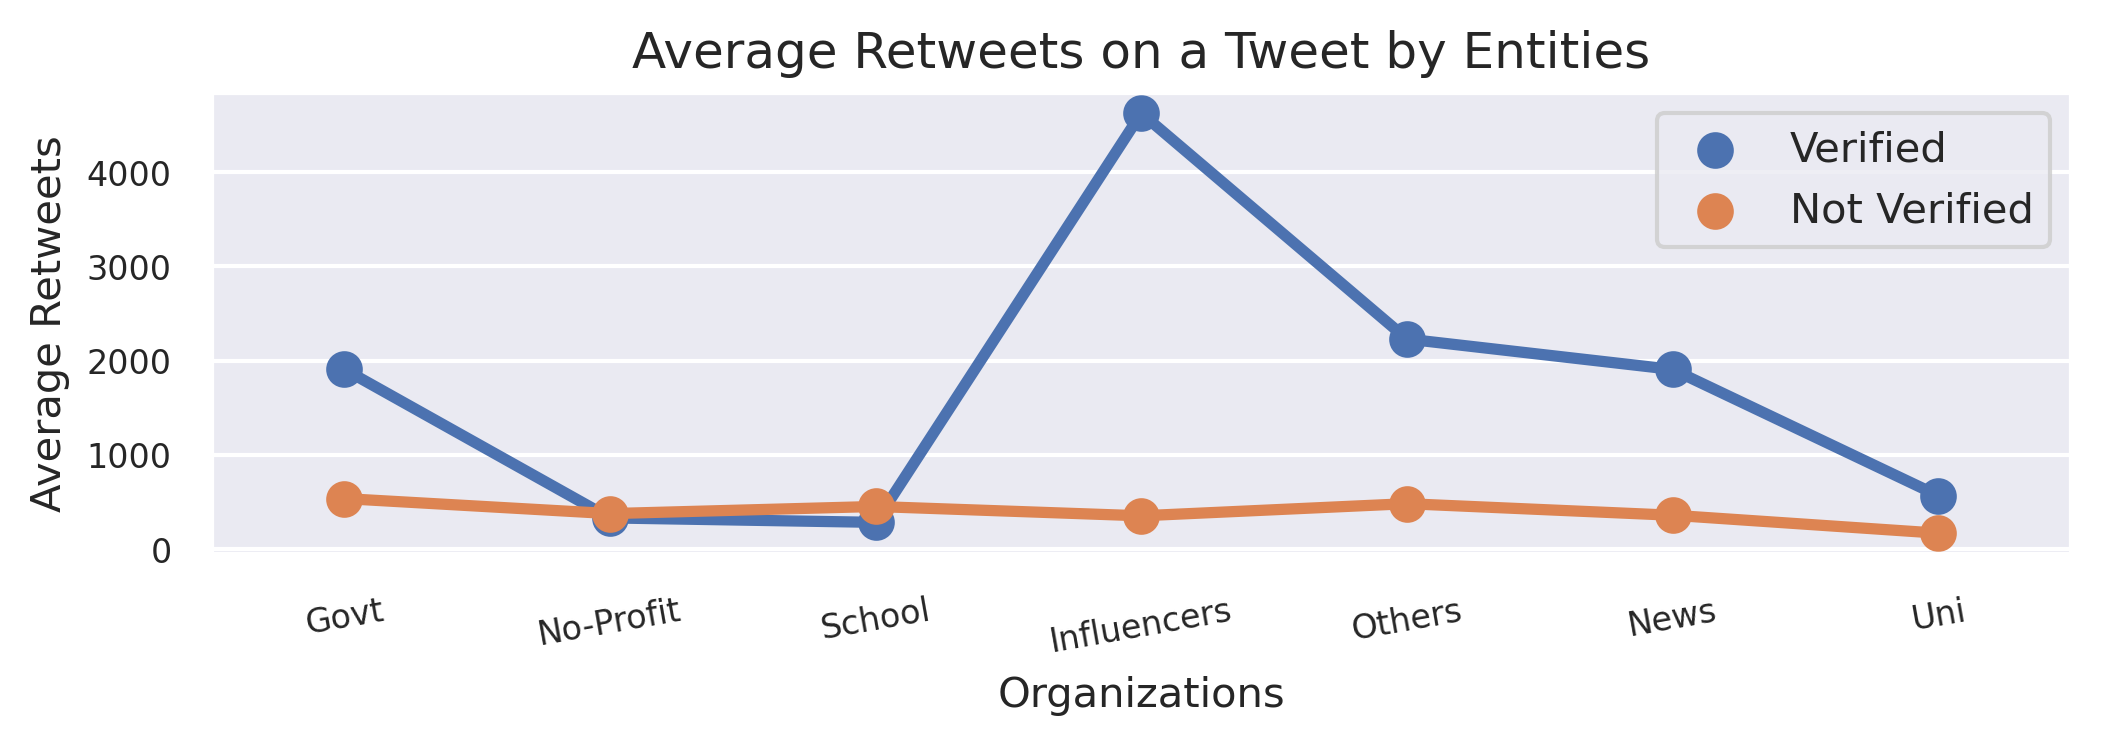

In [319]:
plt.figure(figsize=(8,2), dpi=300)
ax = sns.pointplot(data =df_pd_melted_retweeted, x = 'Category', y ='value',  hue = 'Y' )
plt.title('Average Retweets on a Tweet by Entities')
plt.ylabel('Average Retweets', fontsize = 10)
plt.xlabel('Organizations', fontsize = 10)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
legend_labels = ['Verified', 'Not Verified']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, legend_labels)
ax.set_xticklabels(['Govt', 'No-Profit', 'School', 'Influencers', 'Others', 'News', 'Uni'], rotation = 10)
plt.show()